In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import joblib

In [2]:
# 1. Lire les données depuis un fichier .txt
data = []
with open("sieve_logs.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

for line in lines[1:]:  # skip header
    if ',' in line:
        category, log = line.strip().split(',', 1)
        data.append((category.strip(), log.strip()))

df = pd.DataFrame(data, columns=["category", "log"])

In [3]:
# 2. TF-IDF vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["log"])
y = df["category"]

In [10]:
# 3. Split en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("\n=======================\n1. Modèle Surentraîné (Sans limite)\n=======================\n")
model_overfit = DecisionTreeClassifier(random_state=42)
model_overfit.fit(X_train, y_train)
pred1 = model_overfit.predict(X_test)
print(classification_report(y_test, pred1, zero_division=0))

print("\n=======================\n2. Méthode 1: max_depth = 5 (Élagage)\n=======================\n")
model_pruned = DecisionTreeClassifier(max_depth=5, random_state=42)
model_pruned.fit(X_train, y_train)
pred2 = model_pruned.predict(X_test)
print(classification_report(y_test, pred2, zero_division=0))

print("\n=======================\n3. Méthode 2: GridSearchCV pour trouver le meilleur max_depth\n=======================\n")
params = {"max_depth": [3, 5, 10, 15, None]}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=params, cv=5)
grid.fit(X_train, y_train)
print(f"Meilleur paramètre trouvé: {grid.best_params_}")
pred3 = grid.predict(X_test)
print(classification_report(y_test, pred3, zero_division=0))


1. Modèle Surentraîné (Sans limite)

                              precision    recall  f1-score   support

       authentication-failed       0.91      0.89      0.90       341
      authentication-success       0.89      0.92      0.90       340
           connection-closed       0.91      0.92      0.91       366
           connection-failed       0.93      0.93      0.93       346
           connection-opened       0.93      0.92      0.92       357
          database-operation       0.99      0.99      0.99       357
           directory-changed       0.83      0.79      0.81       356
           directory-created       0.96      0.99      0.98       369
           directory-deleted       0.78      0.84      0.81       335
         file-action-failure       1.00      1.00      1.00       319
                file-deleted       0.86      0.81      0.83       381
           file-modification       0.81      0.86      0.83       342
                   file-read       0.99      0.98  

In [11]:
# 4. Sauvegarde du meilleur modèle
joblib.dump(grid.best_estimator_, "meilleur_modele.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
print("✅ Modèle et vectorizer sauvegardés avec succès.")

✅ Modèle et vectorizer sauvegardés avec succès.


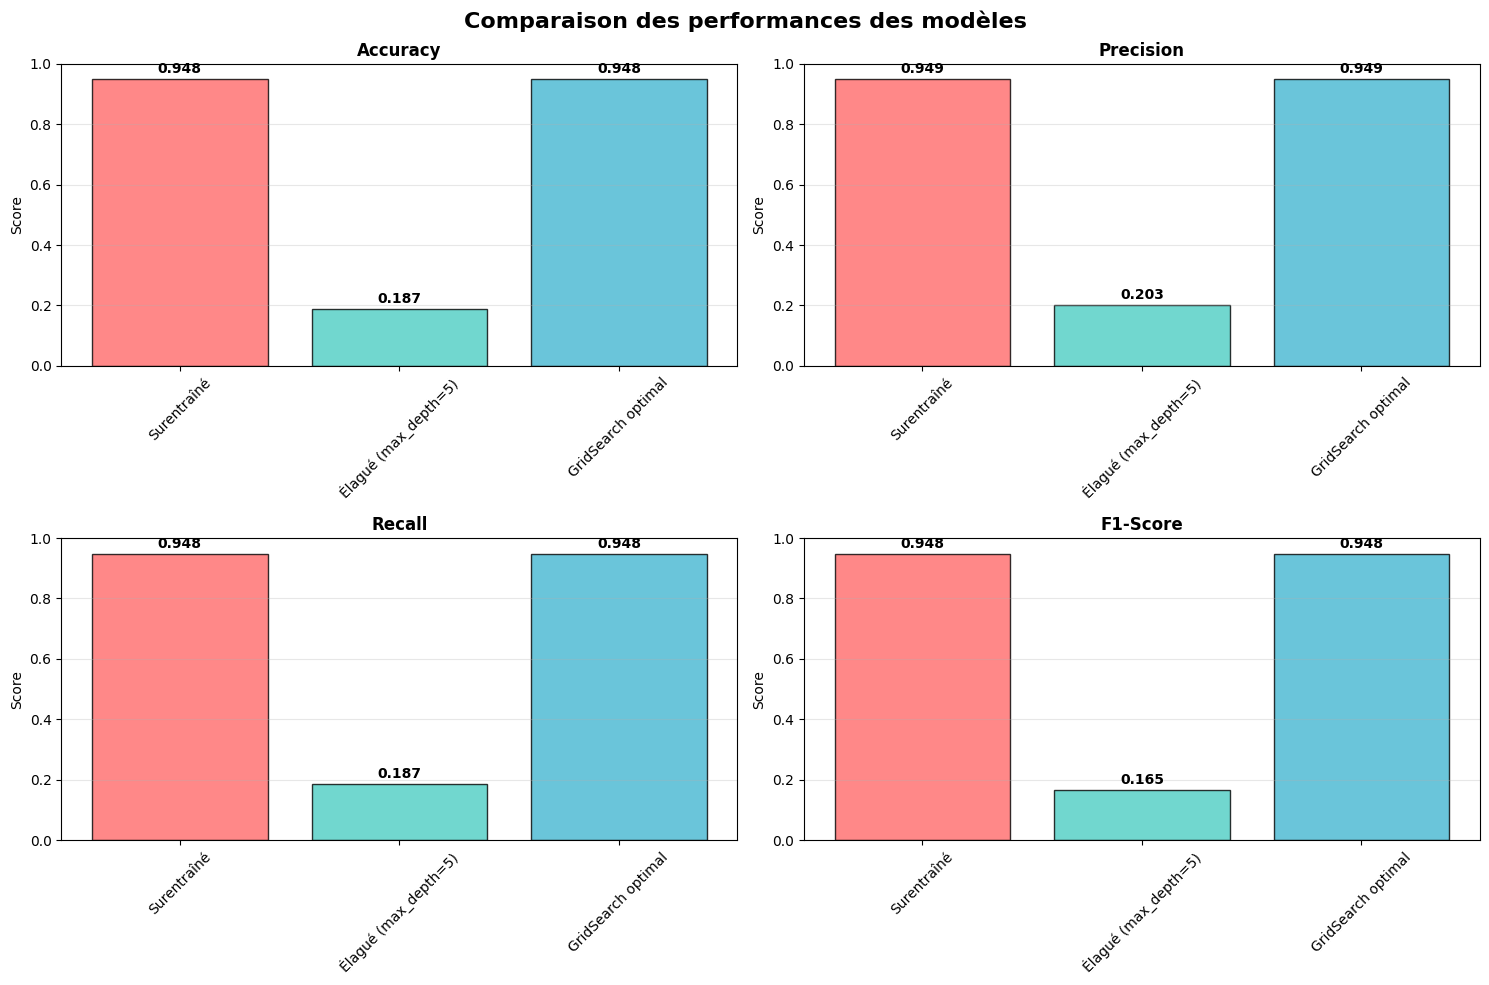

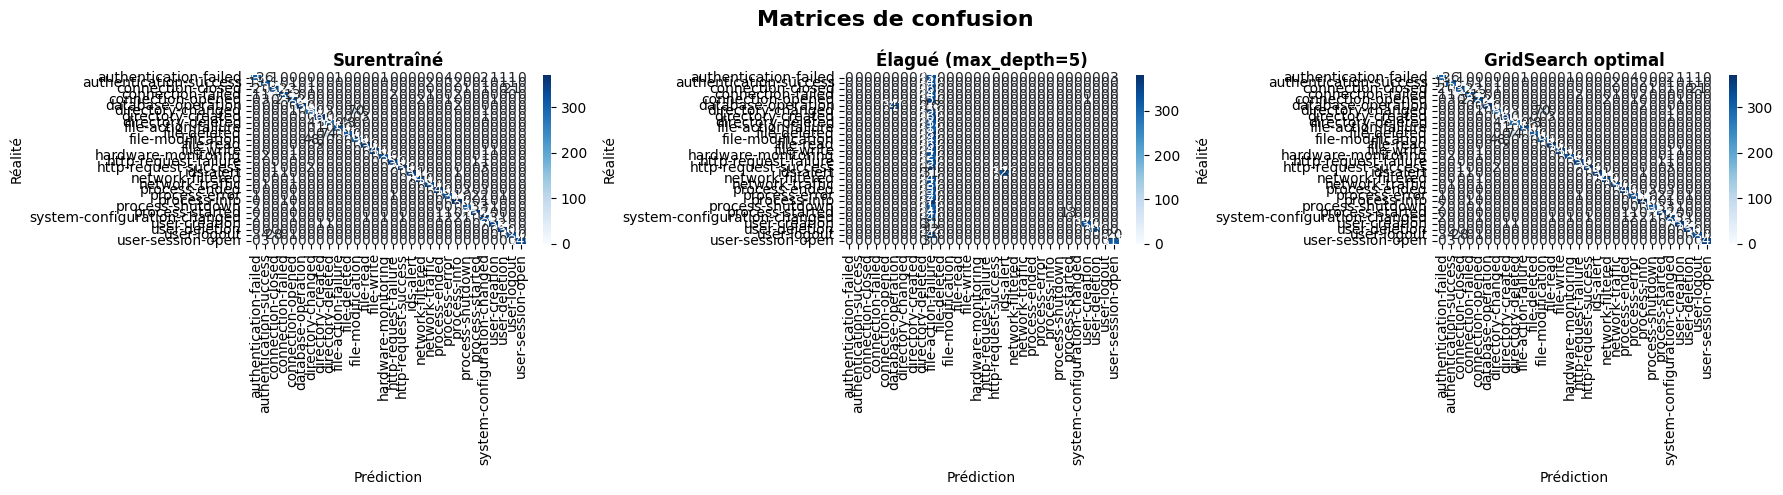

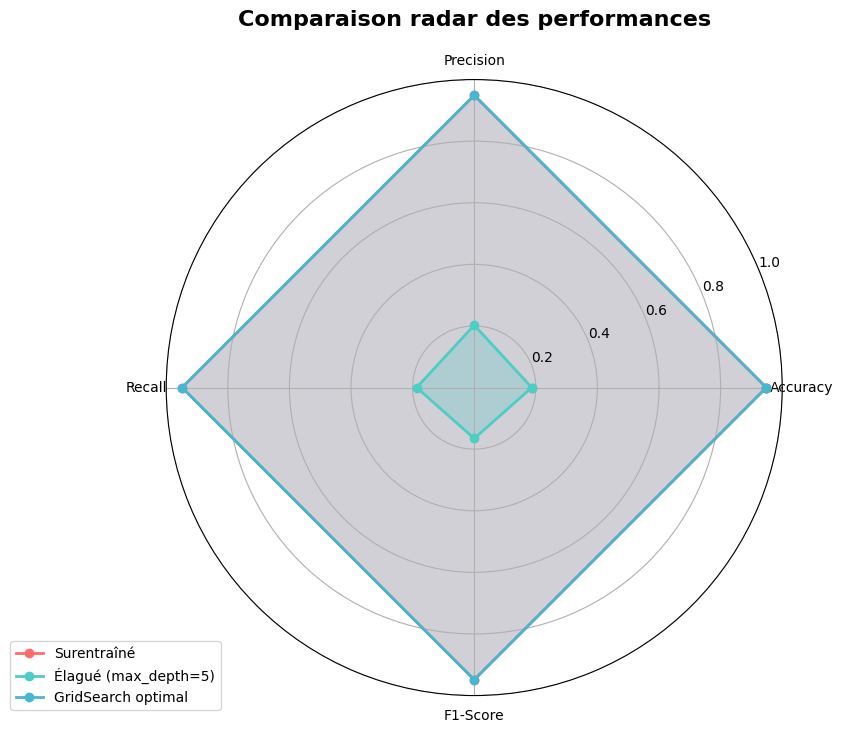

📊 Visualisations générées avec succès!

🏆 Meilleur modèle selon GridSearch: {'max_depth': None}
🎯 Accuracy du meilleur modèle: 0.948


In [9]:
# 5. Visualisation des résultats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import numpy as np

# Configuration du style
plt.style.use('default')
sns.set_palette("husl")

# Calculer les métriques pour chaque modèle
models = ['Surentraîné', 'Élagué (max_depth=5)', 'GridSearch optimal']
predictions = [pred1, pred2, pred3]

metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

for pred in predictions:
    metrics['Accuracy'].append(accuracy_score(y_test, pred))
    metrics['Precision'].append(precision_score(y_test, pred, average='weighted', zero_division=0))
    metrics['Recall'].append(recall_score(y_test, pred, average='weighted', zero_division=0))
    metrics['F1-Score'].append(f1_score(y_test, pred, average='weighted', zero_division=0))

# 1. Graphique en barres comparant les métriques
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Comparaison des performances des modèles', fontsize=16, fontweight='bold')

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, (metric, values) in enumerate(metrics.items()):
    ax = axes[i//2, i%2]
    bars = ax.bar(models, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax.set_title(f'{metric}', fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    
    # Ajouter les valeurs sur les barres
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Matrices de confusion pour chaque modèle
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Matrices de confusion', fontsize=16, fontweight='bold')

for i, (model_name, pred) in enumerate(zip(models, predictions)):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    axes[i].set_title(f'{model_name}', fontweight='bold')
    axes[i].set_xlabel('Prédiction')
    axes[i].set_ylabel('Réalité')

plt.tight_layout()
plt.show()

# 3. Graphique radar comparant tous les modèles
def create_radar_chart():
    categories = list(metrics.keys())
    N = len(categories)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Fermer le cercle
    
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))
    
    for i, model in enumerate(models):
        values = [metrics[cat][i] for cat in categories]
        values += values[:1]  # Fermer le cercle
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 1)
    ax.set_title('Comparaison radar des performances', size=16, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    ax.grid(True)
    
    plt.show()

create_radar_chart()

print("📊 Visualisations générées avec succès!")
print(f"\n🏆 Meilleur modèle selon GridSearch: {grid.best_params_}")
print(f"🎯 Accuracy du meilleur modèle: {metrics['Accuracy'][2]:.3f}")